In [1]:
import os
import sys
import feather
import warnings

import numpy as np # Numerical computing
import pandas as pd # Data manipulation

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 
from scipy import stats # Statistical library
from sklearn.decomposition import PCA # PCA from scikit-learn

sys.path.append('../')
from src import utils, plots, tests, enrich

warnings.filterwarnings('ignore')

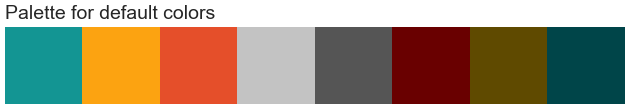

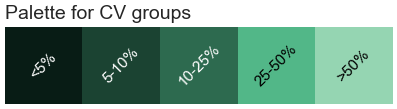

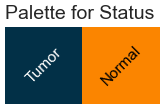

In [2]:
# Create a dictionary for a greyscale color palette with 9 colors
def_colors = [
    "#139593", "#fca311", "#e54f2a",
    "#c3c3c3", "#555555",
    "#690000", "#5f4a00", "#004549"
]

status_colors = {
    "Tumor": "#023047",
    "Normal": "#fb8500",
}
regulation_colors = {
    'Up': "#023047",
    'Down': '#fb8500'
}

cv_group_palettes = {
    "<5%":  "#081c15",  
    "5-10%":  "#1b4332",  
    "10-25%": "#2d6a4f",  
    "25-50%": "#52b788",  
    ">50%": "#95d5b2",  
}

# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

plots.color_palette(
    def_colors, 
    save=False
)

plots.color_palette(
    cv_group_palettes,
    name="CV groups",
    save=False
)

plots.color_palette(
    status_colors,
    name="Status",
    save=False
)

In [3]:
notebook_name = "8_proteoformAnalysis"
data_path = "./data/processed/"
input_path = f"./data/results/"
output_path = f"./data/results/{notebook_name}/"
figure_path = f"./figures/{notebook_name}/"

# Create the output folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create figure folder structure, if needed
if save_to_folder:
    for i in figure_formats:
        cur_folder = figure_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)

In [4]:
# Get the All Proteins Identified in the NBL dataset
background = list(set(feather.read_dataframe("./data/prepared/NBL_directDIA_May2024_protein.feather").index))

## Load the data

### Metadata

In [5]:
# Open the feather file
metadata = feather.read_dataframe(f"{data_path}MatchedPatient_TumorNormal_Metadata.feather")
utils.print_shape(metadata, "Metadata")
metadata.head()

Metadata data has 20 rows and 15 columns


,Filename,Date,Samples,Slot,UniqueNames,BCCHR ID,ID,Group,Differentiation,MKI,INPC,NMYC,Location,Location-Note,Info
9,[67] 20240313_GB_NBL-macro-74_Slot1-58_1_399.h...,20240313,NBL-macro-74,Slot1-58,NBL-macro-74_Slot1-58,74.0000,9.0000,Normal,None,None,None,None,AG,None,True
13,[68] 20240313_GB_NBL-macro-75_Slot1-59_1_400.h...,20240313,NBL-macro-75,Slot1-59,NBL-macro-75_Slot1-59,75.0000,13.0000,Normal,None,None,None,None,AG,None,True
15,[69] 20240313_GB_NBL-macro-76_Slot1-60_1_401.h...,20240313,NBL-macro-76,Slot1-60,NBL-macro-76_Slot1-60,76.0000,14.0000,Normal,None,None,None,None,AG,None,True
36,[71] 20240313_GB_NBL-macro-78_Slot1-62_1_403.h...,20240313,NBL-macro-78,Slot1-62,NBL-macro-78_Slot1-62,78.0000,33.0000,Normal,None,None,None,None,AG,None,True
43,[152] 20240322_GB_NBL-macro-80_Slot1-71_1_506....,20240322,NBL-macro-80,Slot1-71,NBL-macro-80_Slot1-71,80.0000,38.0000,Normal,None,None,None,None,AG,None,True


### Peptide Data

#### Peptide Info

In [6]:
# Peptide Information
peptide_info = feather.read_dataframe(f"{data_path}MatchedPatient_TumorNormal_PeptideLevel_InfoData.feather")
utils.print_shape(peptide_info, "Peptide Info")
peptide_info.head()

Peptide Info data has 117,290 rows and 11 columns


,Protein,Peptide,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,PeptideID
0,A0A024RBG1,MKFKPNQTR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,1,10,181,0,23.7569,False,1
1,A0A024RBG1,TYDREGFK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,10,18,181,0,23.7569,False,2
2,A0A024RBG1,SEQEDEVLLVSSSR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,27,41,181,0,23.7569,False,3
3,A0A024RBG1,LLGIFEQNQDR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,90,181,0,23.7569,False,4
4,A0A024RBG1,LLGIFEQNQDRK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,91,181,1,23.7569,False,5


#### Expanded Info Data

In [7]:
expanded_info_data = feather.read_dataframe( f"{input_path}expanded_info_data_updated.feather")
print(expanded_info_data.shape)
expanded_info_data = expanded_info_data[expanded_info_data['ProteoformGroup'] > -1]
print(expanded_info_data.shape)
expanded_info_data.head()

(117215, 17)
(115877, 17)


,Protein,Peptide,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,PeptideID,TumorRegulation,pval,adj.pvalue,isSignificant,ProteoformGroup,cluster_id
0,A0A024RBG1,MKFKPNQTR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,1,10,181,0,23.7569,False,1,Up,0.0034,0.0132,False,0.0000,3
1,A0A024RBG1,TYDREGFK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,10,18,181,0,23.7569,False,2,Down,0.0000,0.0000,True,1.0000,0
2,A0A024RBG1,SEQEDEVLLVSSSR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,27,41,181,0,23.7569,False,3,Down,0.0124,0.0400,False,0.0000,6
3,A0A024RBG1,LLGIFEQNQDR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,90,181,0,23.7569,False,4,Down,0.1599,0.3053,False,1.0000,0
4,A0A024RBG1,LLGIFEQNQDRK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,91,181,1,23.7569,False,5,Down,0.4427,0.6194,False,1.0000,0


#### Proteoform Info Data

Selecting the multiple peptide proteoform groups. And splitting the single peptide significant peptides into another list for further analysis.

In [8]:
proteoform_info = expanded_info_data[[
    "Protein", "Peptide", "PeptideID", 
    "proteinDescription", "geneName", 
    "startpos", "endpos", "seqLength", 
    "trace", "Cov%", "isCAP",
    "adj.pvalue", "TumorRegulation", 
    "isSignificant", "ProteoformGroup"
]].rename(columns={"ProteoformGroup": "pfg"})
# Create Proteoform Groups with at least 2 peptides 
prf_grps = proteoform_info.groupby("Protein")["pfg"].value_counts()
proteoform_info["Proteoform"] = proteoform_info['Protein'] + "_" + proteoform_info['pfg'].astype(int).astype(str)

proteoform_info.set_index(["Protein", "Peptide"], inplace=True)

# Save the Proteoform Info
proteoform_info.to_feather(f"{output_path}proteoform_info.feather")

utils.print_shape(proteoform_info, "Expanded Info Data")
proteoform_info.head()

Expanded Info Data data has 115,877 rows and 14 columns


PeptideID  \
Protein    Peptide                     
A0A024RBG1 MKFKPNQTR               1   
           TYDREGFK                2   
           SEQEDEVLLVSSSR          3   
           LLGIFEQNQDR             4   
           LLGIFEQNQDRK            5   

                                                          proteinDescription  \
Protein    Peptide                                                             
A0A024RBG1 MKFKPNQTR       Diphosphoinositol polyphosphate phosphohydrola...   
           TYDREGFK        Diphosphoinositol polyphosphate phosphohydrola...   
           SEQEDEVLLVSSSR  Diphosphoinositol polyphosphate phosphohydrola...   
           LLGIFEQNQDR     Diphosphoinositol polyphosphate phosphohydrola...   
           LLGIFEQNQDRK    Diphosphoinositol polyphosphate phosphohydrola...   

                          geneName  startpos  endpos  seqLength  trace  \
Protein    Peptide                                                       
A0A024RBG1 MKFKPNQTR        NUDT4B         1      10        181      0   
           TYDREGFK         NUDT4B        10      18        181      0   
           SEQEDEVLLVSSSR   NUDT4B        27      41        181      0   
           LLGIFEQNQDR      NUDT4B        79      90        181      0   
           LLGIFEQNQDRK     NUDT4B        79      91        181      1   

                             Cov%  isCAP  adj.pvalue TumorRegulation  \
Protein    Peptide                                                     
A0A024RBG1 MKFKPNQTR      23.7569  False      0.0132              Up   
           TYDREGFK       23.7569  False      0.0000            Down   
           SEQEDEVLLVSSSR 23.7569  False      0.0400            Down   
           LLGIFEQNQDR    23.7569  False      0.3053            Down   
           LLGIFEQNQDRK   23.7569  False      0.6194            Down   

                           isSignificant    pfg    Proteoform  
Protein    Peptide                                             
A0A024RBG1 MKFKPNQTR               False 0.0000  A0A024RBG1_0  
           TYDREGFK                 True 1.0000  A0A024RBG1_1  
           SEQEDEVLLVSSSR          False 0.0000  A0A024RBG1_0  
           LLGIFEQNQDR             False 1.0000  A0A024RBG1_1  
           LLGIFEQNQDRK            False 1.0000  A0A024RBG1_1

#### Peptide Level Quantitative Data from Test

In [9]:
# Peptide Level Raw-Imputed Data
peptide_quan = feather.read_dataframe(f"{data_path}MatchedPatient_TumorNormal_PeptideLevel_TestData.feather")
utils.print_shape(peptide_quan, "Peptide Quant")
peptide_quan.head()

Peptide Quant data has 2,345,800 rows and 13 columns


,Protein,Peptide,PeptideID,Sample,Condition,Intensity,log10(Intensity),adjIntensity,isReal,isCompMiss,imputeW,TechVarW,Weight
0,A0A024RBG1,MKFKPNQTR,1,NBL-macro-74_Slot1-58,Normal,212.0579,2.3265,0.0685,False,False,0.0000,0.9965,0.0943
1,A0A024RBG1,TYDREGFK,2,NBL-macro-74_Slot1-58,Normal,209.3483,2.3209,-0.1467,False,False,0.0000,0.9879,0.0935
2,A0A024RBG1,SEQEDEVLLVSSSR,3,NBL-macro-74_Slot1-58,Normal,3387.1516,3.5298,0.4020,False,True,0.7500,0.9453,0.7682
3,A0A024RBG1,LLGIFEQNQDR,4,NBL-macro-74_Slot1-58,Normal,214.4361,2.3313,-0.0740,True,False,1.0000,0.9572,0.9957
4,A0A024RBG1,LLGIFEQNQDRK,5,NBL-macro-74_Slot1-58,Normal,248.7292,2.3957,0.1671,False,True,0.7500,0.9808,0.7717


### Calculation of Proteoform Quant

The method used to calculate the protein quant is the arithmetic mean of the all the peptides quant.

#### Protein Quant

In [10]:
# Get wide and select proteoform only subset
peptide_data = peptide_quan.pivot_table(
    index=["Protein", "Peptide"], 
    columns="Sample", 
    values="Intensity"
).loc[proteoform_info.index].fillna(0)
# Put the Proteoform column
peptide_data["Proteoform"] = proteoform_info["Proteoform"]

# Group by Proteoform and get the mean
proteoform_data = peptide_data.groupby("Proteoform").mean()
utils.print_shape(proteoform_data, "Proteoform Data")
proteoform_data.head()

Proteoform Data data has 14,475 rows and 20 columns


Sample,NBL-macro-107_Slot1-18,NBL-macro-108_Slot1-19,NBL-macro-109_Slot1-20,NBL-macro-117_Slot1-28,NBL-macro-118_Slot1-29,NBL-macro-122_Slot1-77,NBL-macro-13_Slot1-46,NBL-macro-14_Slot1-47,NBL-macro-23_Slot1-06,NBL-macro-33_Slot1-15,NBL-macro-38_Slot1-19,NBL-macro-61_Slot1-44,NBL-macro-74_Slot1-58,NBL-macro-75_Slot1-59,NBL-macro-76_Slot1-60,NBL-macro-78_Slot1-62,NBL-macro-79_Slot1-63,NBL-macro-80_Slot1-71,NBL-macro-82_Slot1-65,NBL-macro-9_Slot1-43
Proteoform,,,,,,,,,,,,,,,,,,,,
A0A024RBG1_0,762.7700,671.3162,1342.7494,1081.8615,1523.4145,234.4695,574.0632,488.4310,685.2726,648.5254,720.1979,451.4826,1799.6047,1016.8687,1009.8302,1548.5928,1019.2361,1033.3406,1907.4949,457.5687
A0A024RBG1_1,92.1605,131.3306,148.5115,93.4946,218.3810,254.9434,103.2321,96.9497,90.4205,97.9022,68.2465,119.6174,224.1712,337.8783,265.9278,236.7944,353.5489,668.0894,258.3292,126.0317
A0A075B6K5_0,4042.9113,1942.4476,1271.4841,2803.3581,1288.3396,4925.4266,2324.8066,3933.0546,888.9110,1153.7506,2211.2059,964.7650,1085.0819,1114.2548,951.4178,1251.6344,2833.5312,1471.4341,1142.7134,2051.0626
A0A075B6S2_0,3301.0886,2665.5040,1070.5192,2647.9081,740.3443,3360.8143,2034.9440,1728.8672,3491.3688,1522.2955,5229.1099,1160.8924,1185.9465,879.9619,812.6324,885.2639,920.1371,2726.2654,840.9618,2237.5050
A0A0B4J1V6_0,1150.7997,1524.2463,802.0369,943.0734,534.8279,3351.7514,471.7204,718.9877,568.6080,556.7307,474.6624,513.5904,1110.9714,1187.5918,1084.9788,1199.4298,1307.5298,1312.2809,1001.5667,1035.7275


In [11]:
status_dict = {
    "Tumor": metadata[metadata["Group"] == "Tumor"]["UniqueNames"].values.tolist(),
    "Normal": metadata[metadata["Group"] == "Normal"]["UniqueNames"].values.tolist(),
}
sample_colors = {
    metadata["UniqueNames"].values[i]: status_colors[metadata["Group"].values[i]] for i in range(metadata.shape[0])
}


# Downstream Analysis

## Initial Look at the Data

In [12]:
# Normalize the data by Centering Medians
centered_data = proteoform_data.copy()

centered_data = (
    (centered_data / centered_data.median()) * 
    (10**(int(np.log10(centered_data.median(axis=1).median()))))
)

# Save the Centered Data
centered_data.to_feather(f"{output_path}centered_protein_data.feather")

centered_data.describe()

Sample,NBL-macro-107_Slot1-18,NBL-macro-108_Slot1-19,NBL-macro-109_Slot1-20,NBL-macro-117_Slot1-28,NBL-macro-118_Slot1-29,NBL-macro-122_Slot1-77,NBL-macro-13_Slot1-46,NBL-macro-14_Slot1-47,NBL-macro-23_Slot1-06,NBL-macro-33_Slot1-15,NBL-macro-38_Slot1-19,NBL-macro-61_Slot1-44,NBL-macro-74_Slot1-58,NBL-macro-75_Slot1-59,NBL-macro-76_Slot1-60,NBL-macro-78_Slot1-62,NBL-macro-79_Slot1-63,NBL-macro-80_Slot1-71,NBL-macro-82_Slot1-65,NBL-macro-9_Slot1-43
count,14475.0000,14475.0000,14475.0000,14475.0000,14475.0000,14475.0000,14475.0000,14475.0000,14475.0000,14475.0000,14475.0000,14475.0000,14475.0000,14475.0000,14475.0000,14475.0000,14475.0000,14475.0000,14475.0000,14475.0000
mean,254.7958,190.6040,172.3961,258.4233,202.2210,264.7616,245.4101,252.8224,217.3170,198.8420,208.7459,174.7847,176.7100,145.1847,174.8805,173.0537,139.1183,181.3553,189.9643,246.4442
std,1060.3865,693.0453,504.0557,1780.9864,1060.8197,1377.3814,1045.2659,1017.3769,682.1633,543.2343,604.8294,497.6321,895.8389,541.1197,792.2528,723.7603,545.7280,792.8473,1011.3880,907.4146
min,2.9291,2.7163,2.0938,2.6374,2.5494,1.8617,2.4398,2.5024,2.6701,2.4811,3.0380,2.3933,2.0368,1.4358,1.8876,1.7462,1.4285,0.9656,2.1813,2.5699
25%,65.4997,41.3358,69.8997,69.0710,39.6396,39.8485,64.9593,65.6388,65.6376,64.6401,62.6556,69.6756,34.8916,31.9601,33.1715,33.2272,32.7589,28.3762,34.7171,65.6004
50%,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000
75%,191.9166,178.4370,165.9660,179.5501,180.5897,192.8124,185.5554,188.1200,183.2350,185.8929,190.3301,163.4271,166.0087,157.3656,168.8875,166.3133,150.8498,166.3071,172.7964,188.5037
max,81376.9008,61565.8597,43821.0015,175542.5044,112188.7942,100878.1629,77543.8405,48952.9113,32243.6035,36562.7671,44027.0196,31189.2791,83952.7781,57115.6233,75086.0488,69461.9247,56822.9751,40083.9082,97530.1664,51134.5439


### Normality Check with QQ-Plot

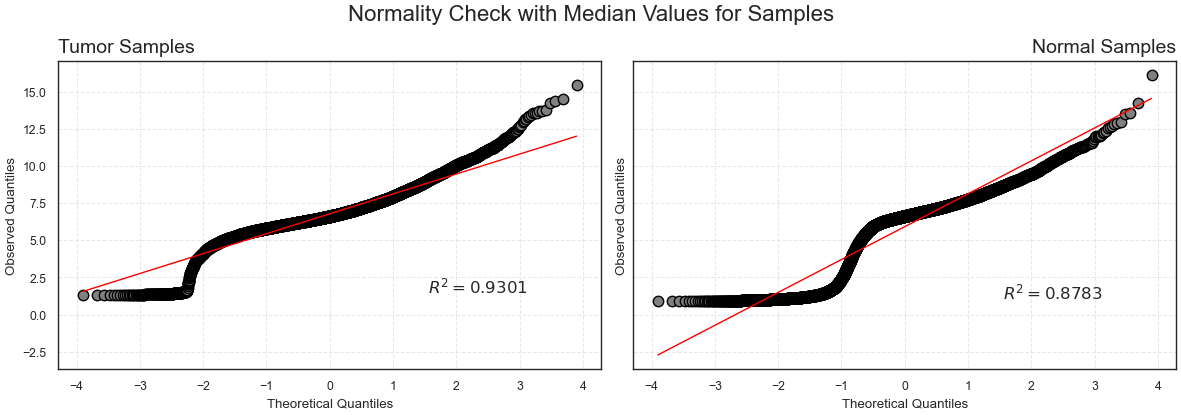

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2 , figsize=(12, 4), sharey=True)
## Tumor Samples
stats.probplot(np.log2(centered_data[status_dict["Tumor"]].median(axis=1)), dist='norm', plot=axes[0], rvalue=True)
# Update the point markers
axes[0].get_lines()[0].set_markerfacecolor('grey')
axes[0].get_lines()[0].set_markeredgecolor('black')
axes[0].get_lines()[0].set_markersize(7.5)
# Update the line
axes[0].get_lines()[1].set_linewidth(1)
axes[0].get_lines()[1].set_color('red')
# Update the text
axes[0].get_children()[2].set_fontsize(12)
# Remove the title
axes[0].set_title("")
axes[0].set_xlabel("Theoretical Quantiles")
axes[0].set_ylabel("Observed Quantiles")
axes[0].set_title("Tumor Samples", fontsize=14, loc="left")
axes[0].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey", zorder=1)
## Normal Samples
stats.probplot(np.log2(centered_data[status_dict["Normal"]].median(axis=1)), dist='norm', plot=axes[1], rvalue=True)
# Update the point markers
axes[1].get_lines()[0].set_markerfacecolor('grey')
axes[1].get_lines()[0].set_markeredgecolor('black')
axes[1].get_lines()[0].set_markersize(7.5)
# Update the line
axes[1].get_lines()[1].set_linewidth(1)
axes[1].get_lines()[1].set_color('red')
# Update the text
axes[1].get_children()[2].set_fontsize(12)
# Remove the title
axes[1].set_title("")
axes[1].set_xlabel("Theoretical Quantiles")
axes[1].set_ylabel("Observed Quantiles")
axes[1].set_title("Normal Samples", fontsize=14, loc="right")
axes[1].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey", zorder=1)
fig.tight_layout()
fig.suptitle("Normality Check with Median Values for Samples", fontsize=16, y=1.05)

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="NormalityCheck_MedianValues_QQPlot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### Boxplot

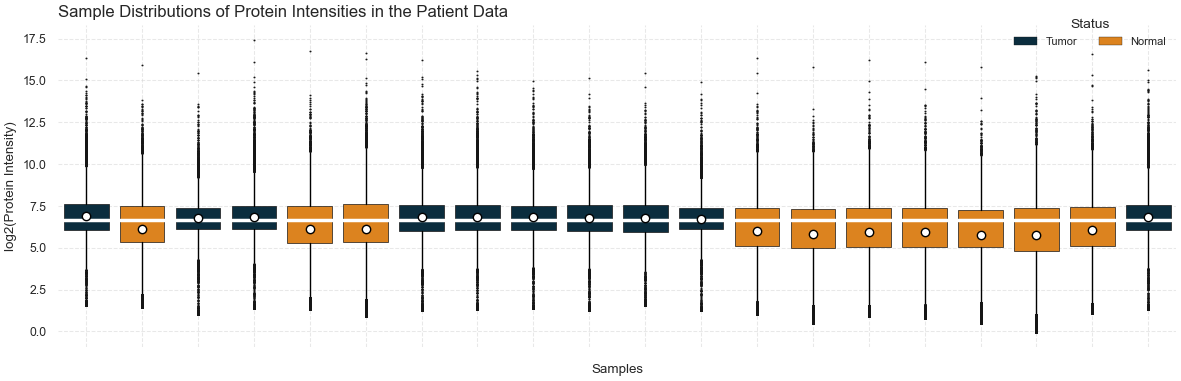

In [14]:
plot_data = np.log2(centered_data).melt(
    var_name="variable", 
    value_name="log2_intensity"
).dropna().set_index("variable")

plot_data = plot_data.merge(
    metadata[["UniqueNames", "Group", "Location"]].set_index("UniqueNames"),
    left_index=True,
    right_index=True,
    how="left"
).reset_index()

# Initialize the figure
fig, ax = plt.subplots(
    figsize=(12, 4)
)

# Create the boxplot
sns.boxplot(
    x="variable",
    y="log2_intensity",
    hue="Group",
    data=plot_data,
    ax=ax,
    dodge=False,
    palette=status_colors,
    # showfliers=False
    fliersize=0.5,
    linewidth=0.5,
    notch=False,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
    medianprops={"color": "white", "linewidth": 2.5},
    whiskerprops={"color": "black", "linewidth": 1},
    capprops={"color": "black", "linewidth": 0},
    # Remove face and edge colors from the boxplot
    # boxprops={"facecolor": "white", "edgecolor": "black"},
)
# Set the x-axis labels

ax.set_xlabel("Samples")
ax.set_ylabel("log2(Protein Intensity)")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment="right")
ax.set_xticklabels([])
ax.set_title("Sample Distributions of Protein Intensities in the Patient Data", fontsize=12, loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# place legend to upper right with 2 columns
ax.legend(loc="upper right", ncol=2, title="Status", title_fontsize=10, fontsize=8, frameon=False, bbox_to_anchor=(1, 1.05))
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="SamplesDistribution_Boxplot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### Density Plots

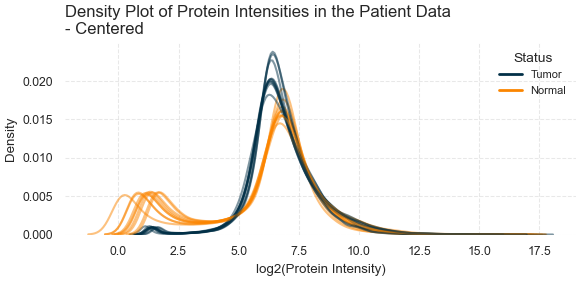

In [15]:
# Initialize the figure
fig, ax = plt.subplots(
    figsize=(6, 3)
)
sns.kdeplot(
    np.log2(centered_data),
    ax=ax,
    # fill=True,
    palette=sample_colors,
    linewidth=1.5,
    alpha=0.5,
    legend=False,
)

ax.set_xlabel("log2(Protein Intensity)")
ax.set_ylabel("Density")
ax.set_title("Density Plot of Protein Intensities in the Patient Data \n- Centered", fontsize=12, loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# Assemble the legend from status colors dictionary tumor and normal two
ax.legend(
    handles=[
        plt.Line2D([0], [0], color=status_colors["Tumor"], lw=2),
        plt.Line2D([0], [0], color=status_colors["Normal"], lw=2),
    ],
    labels=["Tumor", "Normal"],
    title="Status",
    title_fontsize=10,
    fontsize=8,
    frameon=False,
    loc="upper right",
)
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="SampleDistribution_DensityPlot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### CV Plots

CV Data data has 28,950 rows and 4 columns


,mean,median,std
Status,,,
Normal,34.2585,27.0858,27.7392
Tumor,26.0068,20.9437,20.2110


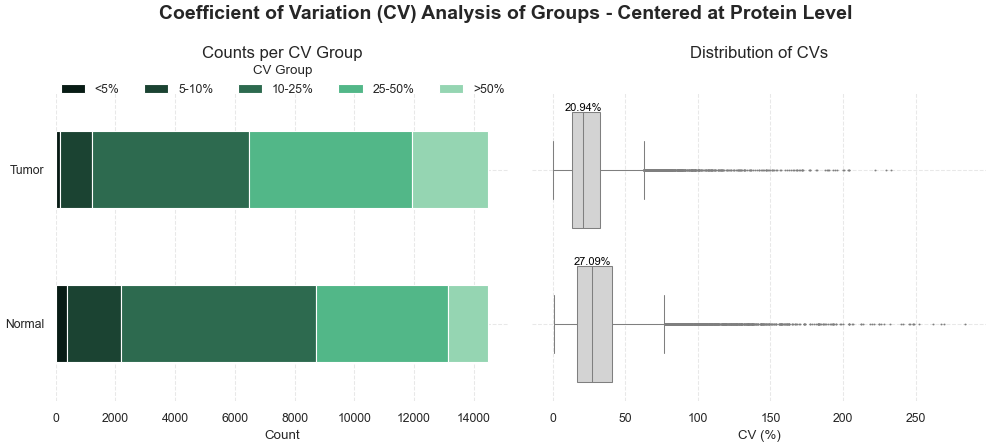

In [16]:
cv_data = pd.DataFrame(index = centered_data.index)
for k, v in status_dict.items():
    cv_data[k] = utils.cv_numpy(
        centered_data[v].values,
        axis=1,
        ignore_nan=True,
        format = "percent"
    )
# Shift CV to start from 0
cv_data = cv_data - cv_data.min().min()

medians = cv_data.median()

plot_data = cv_data.reset_index().melt(
    id_vars="Proteoform",
    var_name="Status",
    value_name="CV"
)

plot_data["CVGroup"] = pd.cut(
    plot_data["CV"],
    bins=[0, 5, 10, 25, 50, 100],
    labels=["<5%", "5-10%", "10-25%", "25-50%", ">50%"],
    right=False
).fillna(">50%")


utils.print_shape(plot_data, "CV Data")

# Create a CV figure with 2 subplots (1 x 2)
# 1: CVGroup Stacked Barplot
# 2: CV Distribution as violin
# Both horizontal
fig, axs = plt.subplots(
    1, 2, 
    figsize=(12, 4), 
    sharey=True,
    gridspec_kw={
        "width_ratios": [1, 1],
        "wspace": 0.05
    }
)

# CV Group Stacked Barplot
cv_counts = plot_data.groupby(["Status", "CVGroup"]).size().unstack().fillna(0)
cv_counts.plot(
    ax=axs[0],
    kind="barh",
    stacked=True,
    color=cv_group_palettes,
)

axs[0].set_xlabel("Count")
axs[0].set_ylabel("")
axs[0].set_title("Counts per CV Group", pad=25, fontsize=12)
# Put the legend on top with 5 columns
axs[0].legend(title="CV Group", frameon=False, bbox_to_anchor=(0.5, 1.125), ncol=5, loc="upper center")
axs[0].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

# CV Distribution as boxplot
sns.boxplot(
    data=plot_data,
    x="CV",
    y="Status",
    ax=axs[1],
    color="lightgrey",
    linewidth=0.75,
    width=0.75,
    # outlier size
    fliersize=0.5
)

axs[1].set_xlabel("CV (%)")
axs[1].set_ylabel("")
axs[1].set_title("Distribution of CVs", pad=25, fontsize=12)
axs[1].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

# Annotate the median CVs on the boxplot
for i, v in enumerate(medians):
    axs[1].text(
        v, i-0.4, f"{v:.2f}%",
        va="center",
        ha="center",
        color="black",
        fontsize=8
    )

sns.despine(left=True, bottom=True)
plt.tight_layout()
fig.suptitle("Coefficient of Variation (CV) Analysis of Groups - Centered at Protein Level", fontsize=14, fontweight="bold", y=1.10)

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="ProteinCVAnalysis",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

plot_data.groupby("Status")["CV"].agg(["mean", "median", "std"])

## Correlation Analysis

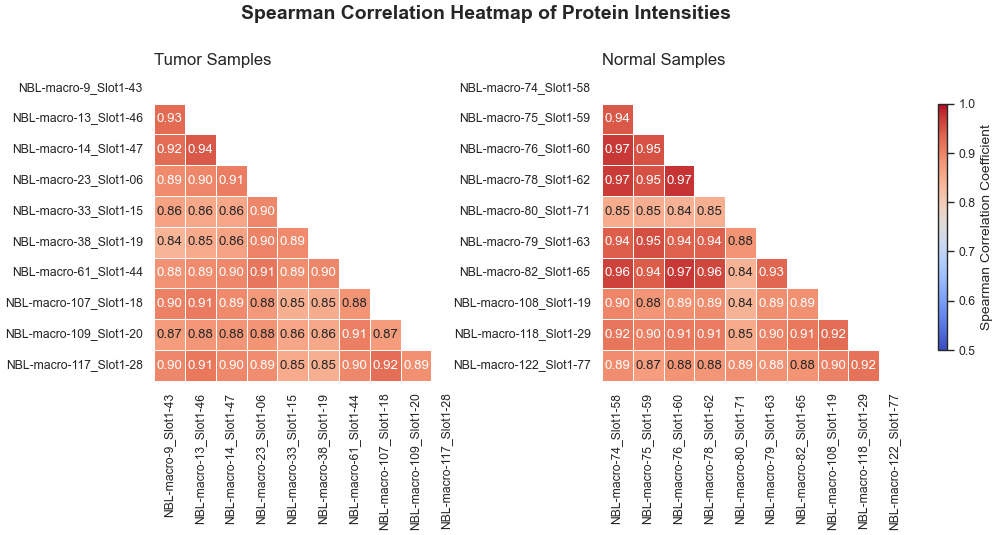

In [17]:
corrMethod = "spearman"
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 4),
    # sharey=True, sharex=True,
    gridspec_kw={"width_ratios": [1, 1], "wspace": 0.05}
)

## Tumor Samples
plot_data = centered_data[status_dict["Tumor"]].corr(method=corrMethod)

# mask the upper triangle
mask = np.triu(np.ones_like(plot_data, dtype=bool))
sns.heatmap(
    plot_data,
    ax=axes[0],
    cmap="coolwarm",
    vmin=0.5,
    vmax=1,
    annot=True,
    fmt=".2f",
    mask=mask,
    cbar=False,
    square=True,
    linewidths=0.5,
    # linecolor="lightgrey",
)
axes[0].set_title("Tumor Samples", fontsize=12, loc="left")
axes[0].set_ylabel("")
axes[0].set_xlabel("")
# axes[0].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

## Normal Samples
plot_data = centered_data[status_dict["Normal"]].corr(method=corrMethod)
# mask the upper triangle
mask = np.triu(np.ones_like(plot_data, dtype=bool))
sns.heatmap(
    plot_data,
    ax=axes[1],
    cmap="coolwarm",
    vmin=0.5,
    vmax=1,
    annot=True,
    fmt=".2f",
    mask=mask,
    cbar=False,
    square=True,
    linewidths=0.5,
    # linecolor="lightgrey",
)
axes[1].set_title("Normal Samples", fontsize=12, loc="left")
axes[1].set_ylabel("")
axes[1].set_xlabel("")
# axes[1].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

# Add a title
fig.suptitle(f"{corrMethod.capitalize()} Correlation Heatmap of Protein Intensities", fontsize=14, fontweight="bold", y=1.05)
# plt.tight_layout()

## Add colorbar to the figure
cbar = axes[1].figure.colorbar(
    axes[1].collections[0], ax=axes, orientation="vertical", pad=0.01,
    fraction=0.05, aspect=30, shrink=0.8, anchor=(0.5, 0.5)
)
cbar.set_label(f"{corrMethod.capitalize()} Correlation Coefficient", fontsize=10)

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="ProteinCorrelationHeatmap",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

## Unsupservised Look

### PCA

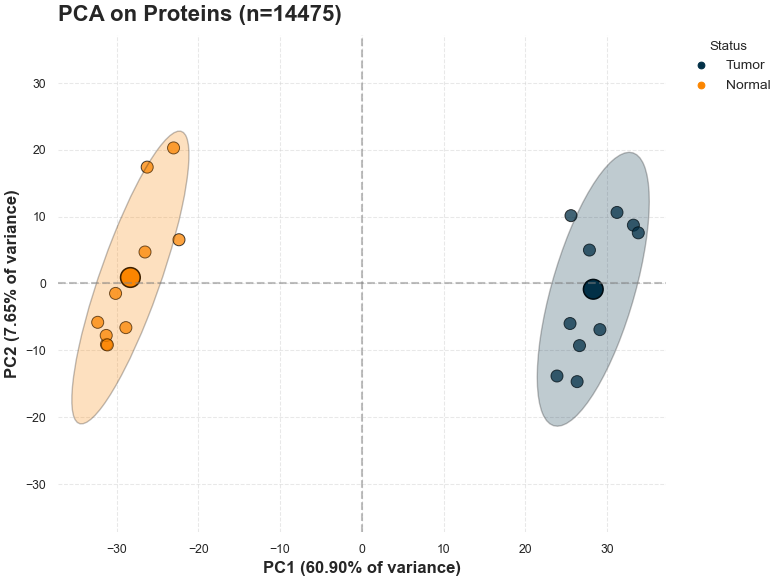

In [18]:
# PCA
# Perform PCA on the centered data
scaler = "minmax"
# Drop any missing values
complete_data = centered_data.dropna()
# Scale the data
scaled_data = utils.scale_the_data(
    complete_data,
    method=scaler,
    axis=1,
    is_log=False
)

# Run the PCA
pca = PCA()
pca_res = pca.fit_transform(scaled_data.T)
pca_exp_var = pca.explained_variance_ratio_

# Set Variables
C1 = 0
C2 = 1
hue_group = "Group"  
style_group = "Differentiation"

# Create variables to be used
comp_locs = [C1, C2]
comp_names = [f'PC{c+1}' for c in comp_locs]

# Set the x and y label names
xlabel = f'{comp_names[0]} ({pca_exp_var[comp_locs[0]]:.2%} of variance)'
ylabel = f'{comp_names[1]} ({pca_exp_var[comp_locs[1]]:.2%} of variance)'
# Build the PCA Plot Data
plot_data = pd.DataFrame(pca_res[:,comp_locs], columns=comp_names)    
plot_data['UniqueNames'] = complete_data.columns
plot_data = plot_data.merge(
    metadata[['UniqueNames', 'Group', 'Location', 'Differentiation']],
    on='UniqueNames',
    how='left'
)

# Find Centroids for each Group-Sex combination calculated with PC1 and PC2 
centroid_data = plot_data.groupby([hue_group])[comp_names].mean()
centroid_data.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(8, 6))

# Centroids
sns.scatterplot(
    data=centroid_data,
    x=comp_names[0],
    y=comp_names[1],
    hue=hue_group,
    # style=style_group,
    palette=status_colors,
    # markers=["o", "s"],
    s=200,
    edgecolor='k',
    legend=False,
    alpha=1,
)

# Technical Replicates
sns.scatterplot(
    data=plot_data,
    x=comp_names[0],
    y=comp_names[1],
    hue=hue_group,
    # style=style_group,
    palette=status_colors,
    # markers=["o", "s"],
    s=75,
    edgecolor='k',
    alpha=0.75,
)

# Setup the X and Y axis limits
# Found the max and min values of the data
minVal = plot_data.iloc[:, :2].min().min()
maxVal = plot_data.iloc[:, :2].max().max()
limit = max(abs(minVal), abs(maxVal))
offset = 0.1 * limit
limit += offset
# Set the limits
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)

## Setup the title and axis labels
# Set the title
ax.set_title(f"PCA on Proteins (n={complete_data.shape[0]})", fontsize=16, fontweight="bold", pad=10, loc="left")
# Set the x-axis label
ax.set_xlabel(xlabel, fontsize=12, fontweight="bold")
# Set the y-axis label
ax.set_ylabel(ylabel, fontsize=12, fontweight="bold")
## Add 0 lines
# Add vertical line
ax.axvline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
# Add horizontal line
ax.axhline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

# Plot the confidence ellipses
# for hue, col in color_palettes[hue_group].items():
for hue, col in status_colors.items():
    x = plot_data.loc[(plot_data[hue_group]==hue), comp_names[0]].values
    y = plot_data.loc[(plot_data[hue_group]==hue), comp_names[1]].values
    if x.size > 1:
        plots.confidence_ellipse(x, y, plt.gca(), n_std=2, edgecolor='k', linewidth=1, alpha=0.25, facecolor=col)

ax.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=10, frameon=False, title="Status")
sns.despine(left=True, bottom=True)
plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Unsupervised_PCA",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### Heatmap with Hierarchical Clustering

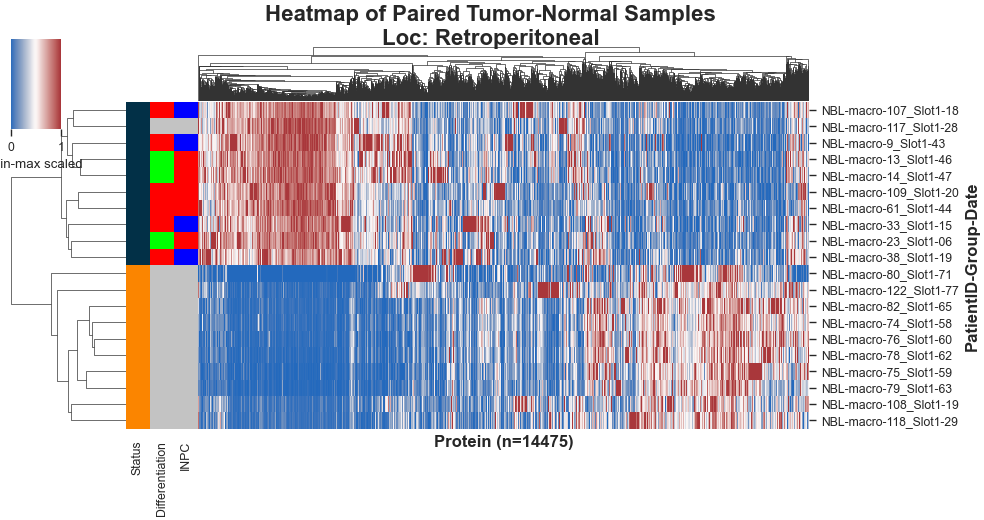

In [19]:
x_colors = pd.DataFrame(
    {
        "Status": metadata["Group"].map(status_colors),
        "Differentiation": metadata["Differentiation"].fillna("NA").map({
            "PD": "#ff0000",
            "UD": "#0000ff",
            "Diff": "#00ff00",
            "NA": "#c3c3c3"
        }),
        "INPC": metadata["INPC"].fillna("NA").map({
            "FH": "#ff0000",
            "UH": "#0000ff",
            "NA": "#c3c3c3"
        }),
    }
).set_index(metadata["UniqueNames"])

g = sns.clustermap(
    scaled_data.T,
    cmap="vlag",
    vmin=0,
    vmax=1,
    figsize=(10, 5),
    # method="ward",
    # metric="euclidean",
    row_cluster=True,
    col_cluster=True,
    xticklabels=False,
    # yticklabels=False,
    cbar_kws={
        "label": "min-max scaled",
        "orientation": "horizontal",
        "pad": 0.01,
        "shrink": 0.15,
        "aspect": 10,
    },
    rasterized=True,
    row_colors=x_colors,
    dendrogram_ratio=(0.15, 0.15),  
)

# Set the title
g.figure.suptitle(
    "Heatmap of Paired Tumor-Normal Samples\nLoc: Retroperitoneal",
    fontsize=16,
    fontweight="bold",
    y=1.05,
)

# Sex y axis-label as Protein(n={})
g.ax_heatmap.set_xlabel("Protein (n={})".format(scaled_data.shape[0]), fontsize=12, fontweight="bold")
g.ax_heatmap.set_ylabel("PatientID-Group-Date", fontsize=12, fontweight="bold")

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Unsupervised_Heatmap",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

## Statistical Analysis

### Determine Equivalence Boundary (LFC) and T-Test LFC Boundary for QuEStVar

Total iterations: 10000

Power Analysis Results:
-----------------------

Input Parameters:
  - Target power: 0.90
  - Sample size (rep) per Group: 10
  - Mean Intra-sample CV: 30.00%
  - Number of Proteins: 1000
  - Significance threshold (p-value): 0.05
  - P-value correction method: fdr
  - Simulation Repeats: 1000

Simulation Results:
Symmetrical equivalence boundaries tested = [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
  - The minimum symmetrical equivalence boundary for target: 0.50


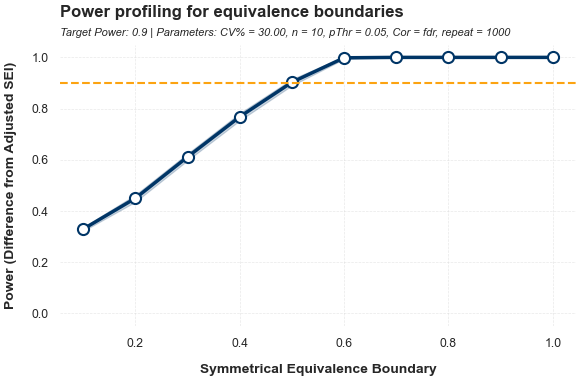

In [20]:
# Search for the optimal equivalence boundary
## Parameter to check
eqBoundary = None
eq_boundaries = np.linspace(0.1, 1.0, 10)

## Essential parameters
power = 0.90
nRep = 10
cvMean = 30
## Secondary parameters
nPrts = 1000
pThr = 0.05
corr = 'fdr'
dfThr = 1.0
cvThr = 10**5
nRepeats = 1000
nCores = None       # Use all available cores
# Simulated data parameters
int_mu = 18
int_sd = 1
int_log2 = True
cv_k = 2
cv_theta = 0.5

# Establish the Adjusted SEI
true_SEI = 1
adjs_SEI = 1 - cvMean/100

# Generate the CV distribution from the mean
cv_dist = tests.skewed_distribution(
    mu = cvMean,
    k = 2,
    theta = 0.5,
    size = nPrts
) / 100

cv_data = pd.DataFrame({
    "cvMean": cvMean,
    "cvDist": cv_dist
})

iterations = []
for eqThr in eq_boundaries:
    for i in range(nRepeats):
        iterations.append((
            cvMean, eqThr, nPrts, nRep, pThr, dfThr, cvThr, corr, i, int_mu, int_sd, int_log2, cv_k, cv_theta
        ))
print(f"Total iterations: {len(iterations)}")

# Run the simulation
results_df = tests.multiprocess_simulation(
    iterations = iterations,
    nCores = 28
)
# Calculate the power from SEI
results_df["calc_SEI"] = results_df["calc_SEI"].astype(float)
results_df["calc_power"] = results_df["calc_SEI"].apply(
    lambda x: tests.calculate_power(
        simulated_sei=x,
        target_sei=adjs_SEI
    )
)

# Print the results
tests.print_power_analysis_results(
    results_df = results_df,
    power = power,
    eqBoundaries = eq_boundaries,
    nRep = nRep,
    cvMean = cvMean,
    nPrts = nPrts,
    pThr = pThr,
    corr = corr,
    # dfThr = dfThr,
    # cvThr = cvThr,
    nRepeat = nRepeats
)
# Visualize the power profile
plots.single_variable_power_profile(
    results_df,
    x_axis_variable="eqThr",
    y_axis_variable = "calc_power",
    target_power = power,
    figtitle="Power profiling for equivalence boundaries",
    xlabel="Symmetrical Equivalence Boundary",
    save=True,
    filepath=figure_path,
    filename="powerProfile_eqThr_linePlot",
    fileformat=figure_formats,
)

### Running QuEStVar and Visualizing the Antlers

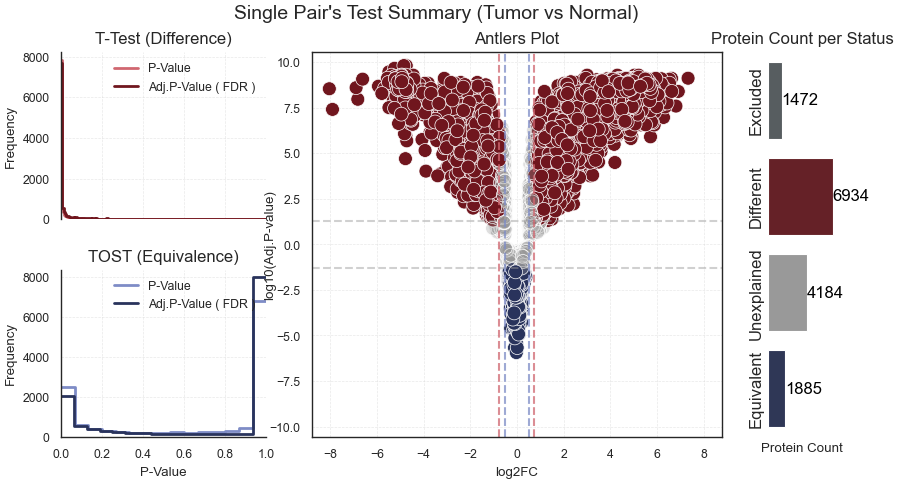

In [21]:
s1_arr = centered_data[status_dict["Tumor"]].values
s2_arr = centered_data[status_dict["Normal"]].values
res_df, info_df = tests.run_questvar(
    S1_arr = s1_arr,
    S2_arr = s2_arr,
    is_log2 = False,
    cv_thr=.75,
    p_thr = 0.05, 
    df_thr = 0.75,
    eq_thr = 0.5,
    var_equal=True,
    is_paired=True,
)

res_df["Status"] = res_df["Status"].replace({
    0: "Unexplained",
    -1: "Different",
    1: "Equivalent"
})

res_df = res_df.join(centered_data.index.to_series().reset_index(drop=True))

plots.single_pair_summary(
    data = res_df,
    total_proteins = centered_data.shape[0],
    pair_names=["Tumor", "Normal"],
    dfThr = 0.75,
    eqThr = 0.5,
    save=True,
    filepath=figure_path,
    filename="QuEStVar_PairSummary",
    fileformat=figure_formats,
)

In [22]:
# Save the results
res_df.to_csv(f"{output_path}QuEStVar_PairSummary.csv", index=False)
res_df

,N1,N2,log2FC,df_p,df_adjp,eq_lp,eq_ladjp,eq_up,eq_uadjp,eq_p,eq_adjp,comb_p,comb_adjp,log10(pval),log10(adj_pval),Status,Proteoform
0,10.0000,10.0000,-0.1037,0.8086,0.8336,0.0902,0.1642,0.1827,0.2646,0.1827,0.2646,0.1827,0.2646,-0.7382,-0.5774,Unexplained,A0A024RBG1_0
1,10.0000,10.0000,-0.9124,0.0000,0.0000,0.0000,0.0000,0.9988,1.0000,0.9988,1.0000,0.0000,0.0000,5.1818,4.6976,Different,A0A024RBG1_1
2,10.0000,10.0000,0.7837,0.0268,0.0380,0.8181,1.0000,0.0010,0.0019,0.8181,1.0000,0.0268,0.0380,1.5715,1.4203,Different,A0A075B6K5_0
4,10.0000,10.0000,-0.3386,0.0615,0.0814,0.0003,0.0007,0.1676,0.2441,0.1676,0.2441,0.1676,0.2441,-0.7757,-0.6124,Unexplained,A0A0B4J1V6_0
6,10.0000,10.0000,0.6367,0.0016,0.0029,0.8184,1.0000,0.0000,0.0000,0.8184,1.0000,0.0016,0.0029,2.8024,2.5394,Unexplained,A0A2Z4LIS9_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14470,10.0000,10.0000,4.7617,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,10.5579,8.8621,Different,Q9Y6Y1_0
14471,10.0000,10.0000,5.2873,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,10.0142,8.6807,Different,Q9Y6Y1_1
14472,10.0000,10.0000,-0.0574,0.7591,0.7890,0.0067,0.0143,0.0188,0.0312,0.0188,0.0312,0.0188,0.0312,-1.7253,-1.5056,Equivalent,Q9Y6Y8_0
14473,10.0000,10.0000,-0.5879,0.0010,0.0019,0.0000,0.0000,0.7531,0.9644,0.7531,0.9644,0.0010,0.0019,2.9922,2.7118,Unexplained,Q9Y6Y8_1


## Enrichment Analysis

### Statistically Different Proteins

Enrichment analysis parameters:
  - match p-value threshold: 1
  - enrichment p-value threshold: 0.001
  - correction method: fdr
  - capping p-value at: 1e-15
  - using hsapiens as organism
  - getting results from ['GO:BP', 'GO:MF', 'GO:CC', 'KEGG', 'REAC', 'WP'] 
  - using 11603 proteins as custom background
  - running multi-query enrichment with 2 queries
      - using 4331 proteins for 'Tumor-Up' enrichment analysis
      - using 2083 proteins for 'Tumor-Down' enrichment analysis
  - will use the 'gProf_pval0.001_Difference' as analysis name for id and save files

Background length: 11603
Tumor-Up: 4331
Tumor-Down: 2083


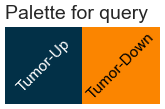

In [23]:
# Variables for the enrichment setup
m_pval = 1 
e_pval = 0.001 
correction = 'fdr' # fdr, bonferroni, g_SCS
pval_cap = 10**-15 
organism = "hsapiens"
sources = ['GO:BP', 'GO:MF', 'GO:CC', 'KEGG', 'REAC', 'WP']
# background = None

enrichment_sets = {
    "Tumor-Up": list(set(res_df[
        (res_df["Status"] == "Different") & (res_df["log2FC"] > 0)
    ]["Proteoform"].str.split("_").str[0])),
    "Tumor-Down": list(set(res_df[
        (res_df["Status"] == "Different") & (res_df["log2FC"] < 0)
    ]["Proteoform"].str.split("_").str[0]))
}
query_palette = {
    "Tumor-Up": "#023047",
    "Tumor-Down": "#fb8500"
}
queries = ["Tumor-Up", "Tumor-Down"]

analysis_name = "gProf_pval{}_Difference".format(e_pval)

enrich.printParams(
    m_pval,
    e_pval,
    correction,
    pval_cap,
    organism,
    sources,
    background,
    enrichment_sets,
    analysis_name
)

print()
print(f"Background length: {len(background)}")
# [k, len(v) for k, v in enrich.items()]
for k, v in enrichment_sets.items():
    print(f"{k}: {len(v)}")

plots.color_palette(
    query_palette,
    name = "query"
)

In [24]:
# Run and Save the Enrichment Analysis
enrich.run_gprofiler(
    query = enrichment_sets,
    background = background,
    organism = organism,
    user_threshold = m_pval,
    signf_threshold = e_pval,
    correction = correction,
    sources = sources,
    pval_cap = pval_cap,
    no_evidences = True,
    no_iea = False,
    ordered = False,
    simplify_cols=True,
    save_path = output_path,
    analysis_name = "gProf_Difference_FullList",
    verbose = True
)

print()

# Read the results
gp_res = pd.read_csv(
    os.path.join(
        output_path, 
        "gProf_Difference_FullList.csv"
    ),
    sep=","
)

# Create a subset of the results with the p-value cutoff
subset_gp_res = gp_res[
    gp_res["p_value"] < e_pval
]

# Save the subset results
subset_gp_res.to_csv(
    f"{output_path}{analysis_name}.csv",
    sep=",",
    index=False
)

df_enrichment = pd.read_csv(f"{output_path}{analysis_name}.csv")

print(f"""After the p-value cutoff of {e_pval} there are total of {df_enrichment.shape[0]} enriched terms.""")

utils.print_series(
    df_enrichment["query"].value_counts(),
    header = f"Number of enriched terms per query with p-val cutoff {e_pval}:",
    tab = 2,
    elements_with_order = queries
)

Capping the p_value at 1e-15
Simplifying the columns.
P-value threshold: 1 
Correction method: fdr
Number of queries: 2
Number of terms per query:
   Tumor-Up -> 18083
   Tumor-Down -> 15184
Number of Unique enriched terms: 19915
Number of total terms saved: 33267
Enrichment result are prepared in 00h:00m:24s

After the p-value cutoff of 0.001 there are total of 878 enriched terms.
Number of enriched terms per query with p-val cutoff 0.001:
   Tumor-Up -> 660
   Tumor-Down -> 218


### Statistically Equivalent Proteins

Enrichment analysis parameters:
  - match p-value threshold: 1
  - enrichment p-value threshold: 0.001
  - correction method: fdr
  - capping p-value at: 1e-15
  - using hsapiens as organism
  - getting results from ['GO:BP', 'GO:MF', 'GO:CC', 'KEGG', 'REAC', 'WP'] 
  - using 11603 proteins as custom background
      - using 1871 proteins for 'Equivalent' enrichment analysis
  - will use the 'gProf_pval0.001_Equivalence' as analysis name for id and save files


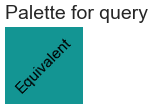

In [25]:
# Variables for the enrichment setup
m_pval = 1 
e_pval = 0.001
correction = 'fdr' # fdr, bonferroni, g_SCS
pval_cap = 10**-15 
organism = "hsapiens"
sources = ['GO:BP', 'GO:MF', 'GO:CC', 'KEGG', 'REAC', 'WP']
# background = None

enrichment_sets = {
    "Equivalent": list(set(
        res_df[
            res_df["Status"] == "Equivalent"
        ]["Proteoform"].str.split("_").str[0]
    ))
}
query_palette = {
    "Equivalent": def_colors[0]
}
queries = ['Equivalent']

analysis_name = "gProf_pval{}_Equivalence".format(e_pval)

enrich.printParams(
    m_pval,
    e_pval,
    correction,
    pval_cap,
    organism,
    sources,
    background,
    enrichment_sets,
    analysis_name
)

plots.color_palette(
    query_palette,
    name = "query"
)

In [26]:
# Run and Save the Enrichment Analysis
enrich.run_gprofiler(
    query = enrichment_sets,
    background = background,
    organism = organism,
    user_threshold = m_pval,
    signf_threshold = e_pval,
    correction = correction,
    sources = sources,
    pval_cap = pval_cap,
    no_evidences = True,
    no_iea = False,
    ordered = False,
    simplify_cols=True,
    save_path = output_path,
    analysis_name = "gProf_Equivalence_FullList",
    verbose = True
)

print()

# Read the results
gp_res = pd.read_csv(
    os.path.join(
        output_path, 
        "gProf_Equivalence_FullList.csv"
    ),
    sep=","
)

# Create a subset of the results with the p-value cutoff
subset_gp_res = gp_res[
    gp_res["p_value"] < e_pval
]

# Save the subset results
subset_gp_res.to_csv(
    f"{output_path}{analysis_name}.csv",
    sep=",",
    index=False
)

eq_enrichment = pd.read_csv(f"{output_path}{analysis_name}.csv")

print(f"""After the p-value cutoff of {e_pval} there are total of {eq_enrichment.shape[0]} enriched terms.""")

utils.print_series(
    eq_enrichment["query"].value_counts(),
    header = f"Number of enriched terms per query with p-val cutoff {e_pval}:",
    tab = 2,
    elements_with_order = queries
)

Capping the p_value at 1e-15
Simplifying the columns.
P-value threshold: 1 
Correction method: fdr
Number of queries: 1
Number of terms per query:
   Equivalent -> 14387
Number of Unique enriched terms: 14387
Number of total terms saved: 14387
Enrichment result are prepared in 00h:00m:09s

After the p-value cutoff of 0.001 there are total of 254 enriched terms.
Number of enriched terms per query with p-val cutoff 0.001:
   Equivalent -> 254


## Enrichment Summary 

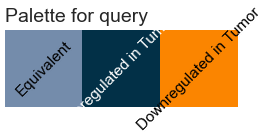

,query,source,native,name,significant,p_value,p_capped,-log10(p_value),-log10(p_capped),Enrichment,GeneRatio,parents
0,Upregulated in Tumor,GO:CC,GO:0031981,nuclear lumen,True,0.0000,0.0000,61.6024,15.0000,1.3386,0.4552,"['GO:0005634', 'GO:0070013']"
1,Downregulated in Tumor,GO:CC,GO:0005737,cytoplasm,True,0.0000,0.0000,58.7836,15.0000,1.2145,0.1922,"['GO:0005622', 'GO:0110165']"
2,Upregulated in Tumor,GO:CC,GO:0005654,nucleoplasm,True,0.0000,0.0000,57.6434,15.0000,1.3461,0.4578,"['GO:0031981', 'GO:0110165']"
3,Upregulated in Tumor,GO:CC,GO:0005634,nucleus,True,0.0000,0.0000,56.8842,15.0000,1.2324,0.4191,['GO:0043231']
4,Upregulated in Tumor,GO:CC,GO:0005622,intracellular anatomical structure,True,0.0000,0.0000,55.7866,15.0000,1.0885,0.3701,['GO:0110165']
...,...,...,...,...,...,...,...,...,...,...,...,...
249,Equivalent,GO:MF,GO:0016740,transferase activity,True,0.0008,0.0008,3.1017,3.1017,1.2398,0.1828,['GO:0003824']
250,Equivalent,GO:BP,GO:0051173,positive regulation of nitrogen compound metab...,True,0.0008,0.0008,3.0941,3.0941,1.2131,0.1788,"['GO:0006807', 'GO:0009893', 'GO:0051171']"
251,Equivalent,GO:BP,GO:0048519,negative regulation of biological process,True,0.0008,0.0008,3.0798,3.0798,1.1433,0.1685,"['GO:0008150', 'GO:0050789']"
252,Equivalent,GO:BP,GO:0006796,phosphate-containing compound metabolic process,True,0.0008,0.0008,3.0798,3.0798,1.2243,0.1805,['GO:0006793']


In [27]:
query_palette = {
    "Equivalent": "#748cab",
    "Upregulated in Tumor": "#023047",
    "Downregulated in Tumor": "#fb8500"
}
plots.color_palette(
    query_palette,
    name = "query"
)
enrichment_data = pd.concat([df_enrichment, eq_enrichment])
enrichment_data['query'] = enrichment_data['query'].replace({
    "Tumor-Up": "Upregulated in Tumor",
    "Tumor-Down": "Downregulated in Tumor",
    "Equivalent": "Equivalent"
})
enrichment_data

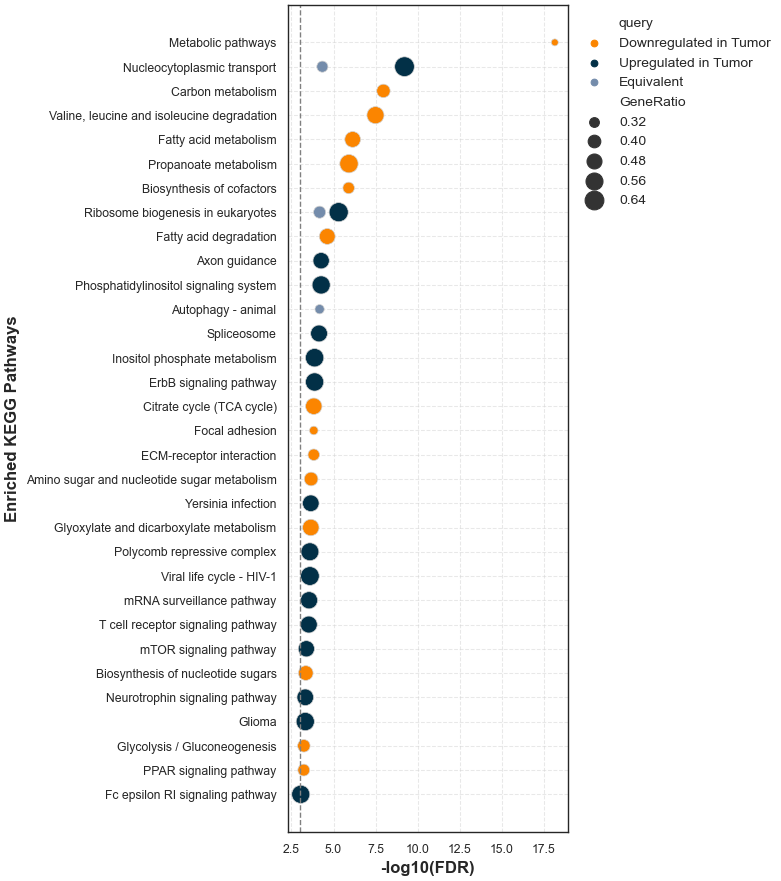

In [28]:
cur_source = "KEGG"
plot_data = enrichment_data[
    (enrichment_data["source"] == cur_source) & 
    (enrichment_data["native"]!=f"{cur_source}:00000")
].sort_values('p_value').copy()
n_unique = plot_data["native"].nunique()

# Initialize the figure
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(8, 1 + n_unique * 0.25),
)

sns.scatterplot(
    ax=ax,
    data=plot_data,
    y="name",
    x="-log10(p_value)",
    hue="query",
    size="GeneRatio",
    edgecolor="lightgray",
    palette=query_palette,
    linewidth=.5,
    sizes=(25, 200),
    legend='brief',
)

# Add line at p-value cutoff
ax.axvline( -np.log10(e_pval), color="gray", linestyle="--", linewidth=1 )

# Add Styling to the plot
ax.set_xlabel("-log10(FDR)", fontsize=12, fontweight="bold")
ax.set_ylabel(f"Enriched {cur_source} Pathways", fontsize=12, fontweight="bold")
# Add grid
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(
    frameon=False,
    fontsize=10,
    title_fontsize=14,
    loc="upper left",
    bbox_to_anchor=(1, 1),
    # title="Enrichment Query",
)
plt.tight_layout()

In [29]:
enrichment_data[enrichment_data['name'] == 'Signal Transduction']

,query,source,native,name,significant,p_value,p_capped,-log10(p_value),-log10(p_capped),Enrichment,GeneRatio,parents
346,Upregulated in Tumor,REAC,REAC:R-HSA-162582,Signal Transduction,True,0.0000,0.0000,7.0475,7.0475,1.1904,0.4048,['REAC:0000000']
146,Equivalent,REAC,REAC:R-HSA-162582,Signal Transduction,True,0.0000,0.0000,4.8489,4.8489,1.2800,0.1887,['REAC:0000000']


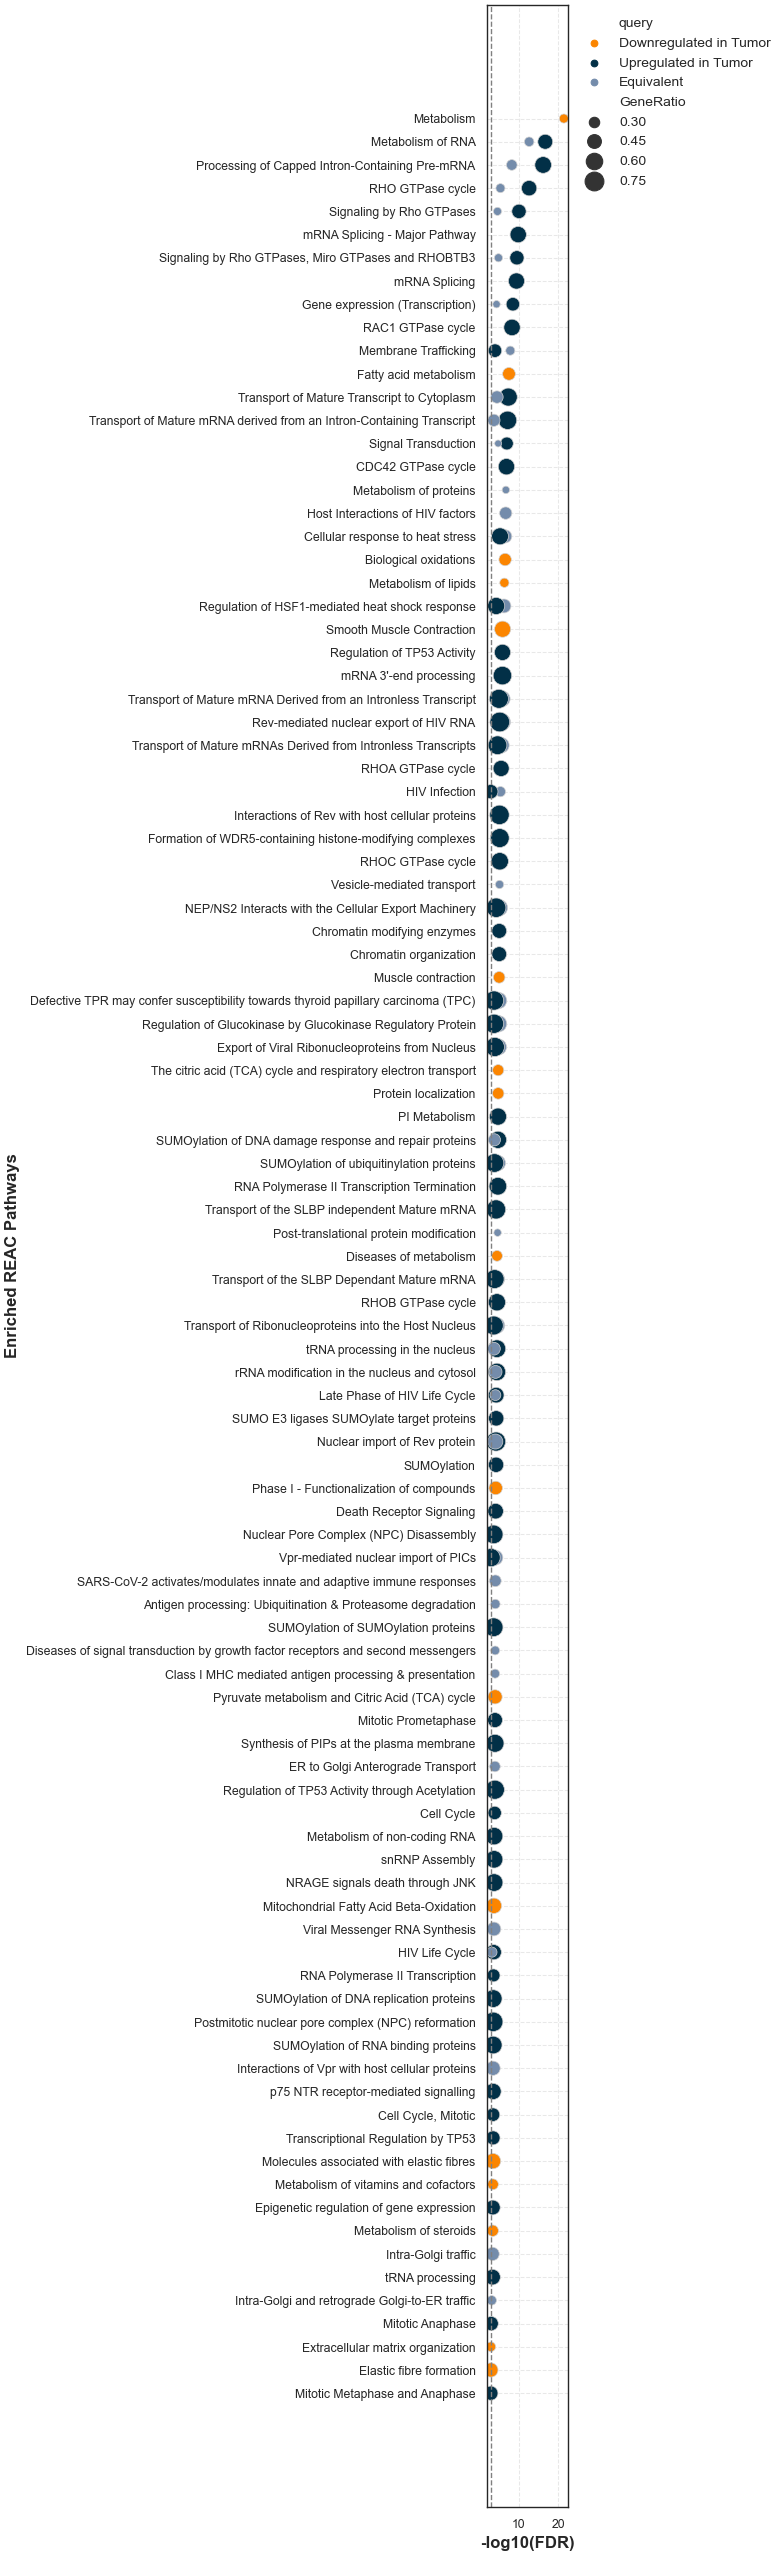

In [30]:
cur_source = "REAC"
plot_data = enrichment_data[
    (enrichment_data["source"] == cur_source) & 
    (enrichment_data["native"]!=f"{cur_source}:00000")
].sort_values('p_value').copy()
n_unique = plot_data["native"].nunique()

# Initialize the figure
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(8, 1 + n_unique * 0.25),
)

sns.scatterplot(
    ax=ax,
    data=plot_data,
    y="name",
    x="-log10(p_value)",
    hue="query",
    size="GeneRatio",
    edgecolor="lightgray",
    palette=query_palette,
    linewidth=.5,
    sizes=(25, 200),
    legend='brief',
)

# Add line at p-value cutoff
ax.axvline( -np.log10(e_pval), color="gray", linestyle="--", linewidth=1 )

# Add Styling to the plot
ax.set_xlabel("-log10(FDR)", fontsize=12, fontweight="bold")
ax.set_ylabel(f"Enriched {cur_source} Pathways", fontsize=12, fontweight="bold")
# Add grid
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(
    frameon=False,
    fontsize=10,
    title_fontsize=14,
    loc="upper left",
    bbox_to_anchor=(1, 1),
    # title="Enrichment Query",
)
plt.tight_layout()